# Explore Neural Network Hyperparameters with TensorFlow

In [16]:
import addutils.toc ; addutils.toc.js(ipy_notebook=True)

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as sk
import sklearn.metrics
from IPython.display import Image
from addutils import css_notebook
from bokeh.models import ColumnDataSource
import time
from ipywidgets import interact
css_notebook()

In [18]:
import bokeh.plotting as bk
bk.output_notebook()

BokehJS successfully loaded.

## Required packages and tools

This notebook requires few additional packages. Please be sure to install them properly before running the notebook.

The main argument we treat in this notebook is TensorFlow, a library for machine learning and deep learning recently open sourced by google. For more information please visit [TensorFlow](http://www.tensorflow.org).

**<font color='red'>WARNING</font>**: this library supports only Linux and Mac OS. At the moment Windows operating system is not supported.

TensorFlow, is conceptually similar to theano; the computation is formally a graph, with nodes representing operations while edges representing tensors (multidimensional data) communicated between operations. According to TensorFlow web site, the flow of tensors through the graph is where TensorFlow gets its name. It is not intended to be only a neural network library but to perform any computation that can be expressed as a graph. TensorFlow automatic differentiation is especially suited for gradient based machine learning algorithms. The library is written in C++ and it has nice Python bindings. Moreover it can run both on CPU and GPU.

We suggest to follows the steps outlined in:

[https://www.tensorflow.org/versions/master/get_started/os_setup.html#pip_install](https://www.tensorflow.org/versions/master/get_started/os_setup.html#pip_install)

we recommend to follow pip installation process:

- first choose which package to install, with or without GPU support
    
- install TensorFlow for python 3 (this notebook use it)
`$ sudo pip3 install --upgrade https://storage.googleapis.com/tensorflow/linux/gpu/tensorflow-0.6.0-cp34-none-linux_x86_64.whl`

If you installed the GPU version of TensorFlow, you must also install the Cuda Toolkit 7.0 and CUDNN 6.5 V2. 

## 1 Create Synthetic data

In order to evaluate how hyperparameters affects performance, it is useful to generate synthetic data for training. The tests will be performed by a single hidden layer feed forward network. The data consist of a simple sinusoid with added random noise (drawn from a standard normal distribution). It is possible to specify a serie of parameters: 

In [19]:
# experiment parameters
# play with the numbers
samples_per_cycle = 100
training_cycles = 20
validation_cycles = 5
amplitude = 1
noise_sigma = 0.1
n_inputs = 100
steps_forward = 1

* `samples_per_cycle`: number of data points drawn for every complete cycle of the sinusoid
* `training_cycles`: number of complete cycles used for training
* `validation_cycles`: number of complete cycles used for validation
* `amplitude`: height of the sinusoid
* `noise_sigma`: standard deviation of the normal distribution used as noise source 
* `n_inputs`: number of previous time steps to consider as input
* `steps_forward`: number of time steps in the future to predict (one: predict the next step, two: predict the step after the next, and so on)

In [20]:
n_cycles = training_cycles + validation_cycles

t = np.arange(0, n_cycles, 1./samples_per_cycle) * 2 * np.pi
y_clean = amplitude * np.sin(t)
np.random.seed(0)
y_noisy = y_clean + noise_sigma * np.random.randn(t.size)

The dataset is generated from the sinusoid taking as many time steps as specified with `n_inputs` parameter. It uses a moving window to take the `n_input` steps starting from the current step. Then it move to the next and takes again `n_input` consecutively. It stops when it reach the end of the sinusoid. The dataset is then shaped as a matrix with the number of columns equal the number of inputs. The desired target is taken from the clean sinusoid, that is the one without added noise. 

In [21]:
vec_size = n_inputs + steps_forward - 1 # -1 accounts for zero based array

X = np.zeros((y_noisy.size-vec_size,n_inputs))
#y = np.zeros((y_noisy.size-vec_size,1))
y = np.zeros((y_clean.size-vec_size,1))

for r in range(y_noisy.size-vec_size):
    X[r,:] = y_noisy[r:r+n_inputs]
    #y[r,:] = y_noisy[r+vec_size]
    y[r,:] = y_clean[r+vec_size]

Once we have the dataset we split it in train and test sets.

In [22]:
# check dimensions, they must be congruent!
split = samples_per_cycle * training_cycles - n_inputs
X_train = X[:split]
X_test = X[split:] 
y_train = y[:split]
y_test = y[split:]

In [23]:
print('X_train shape: %d, %d' % X_train.shape)
print('X_test shape: %d, %d' % X_test.shape)
print('y_train shape: %d, %d' % y_train.shape)
print('y_test shape: %d, %d' % y_test.shape)

X_train shape: 1900, 100
X_test shape: 500, 100
y_train shape: 1900, 1
y_test shape: 500, 1


## 2 Single layer feed forward network

We start with an implementation of a single layer feed forward network with a tanh activation unit. We show how TensorFlow can be used as a general purpose programming library that lets you define, optimize, and evaluate mathematical expressions, especially ones with multi-dimensional arrays. The downside of this feature is that the user must specify every aspect of a neural network when building one.

The following code builds the actual Neural Network. It is possible to specify a serie of parameters. 

* `hidden_size`: number of neuron in the hidden layer
* `batch_size`: number of examples in each batch
* `epochs`: number of epochs
* `learning_rate`: learning rate of the optimizer

The neural network is composed by an hidden layer with tanh activation units and a single linear neuron for the output. It uses simple steepest descent as optimizer. The function `train` update the parameters, that is the weight matrices and biase, while the function `y` calculates the actual output.

In [24]:
hidden_size = 10    # Number of hidden units
output_size = 1    # Number of output units (one)
batch_size = 50     # Minibatch size (how many examples to process in parallel)
epochs = 25         # Total number of passes over all examples (epochs).
learning_rate = 0.01

x = tf.placeholder(tf.float32, [None, n_inputs])
y_ = tf.placeholder(tf.float32, [None, 1])

W_x = tf.Variable(tf.truncated_normal([n_inputs, hidden_size], stddev=0.05))
#b_h = tf.Variable(tf.constant(0.1, shape=[hidden_size]))
b_h = tf.Variable(tf.truncated_normal([hidden_size], stddev=0.05))

h = tf.nn.tanh(tf.matmul(x, W_x) + b_h)

#W_h = tf.Variable(tf.zeros([hidden_size, 1]))
#b_y = tf.Variable(tf.zeros([1]))
W_h = tf.Variable(tf.truncated_normal([hidden_size, 1], stddev=0.05))
b_y = tf.Variable(tf.truncated_normal([1], stddev=0.05))

y = tf.matmul(h, W_h) + b_y

loss = tf.reduce_mean(tf.square(y - y_))
optimizer = tf.train.GradientDescentOptimizer(0.01) # learning rate         
train = optimizer.minimize(loss)

sess = tf.Session()

sess.run(tf.initialize_all_variables())

The following code displays two graphs. One with the training and validation error for each epoch and one with the cost value for each epoch. To see the graph updating dynamically please go to the [<font color='red'>CODE</font>](#CODE) cell and run it.

In [25]:
train_accuracy_vector = []
test_accuracy_vector = []
cost_vector = []
input_vector = []

s_cost = ColumnDataSource(data=dict(x=input_vector, y=cost_vector))
s_train = ColumnDataSource(data=dict(x=input_vector, y=train_accuracy_vector))
s_test = ColumnDataSource(data=dict(x=input_vector, y=test_accuracy_vector))

fig1 = bk.figure(plot_width=500, 
                 plot_height=300, 
                 x_axis_label='Epochs',
                 y_axis_label='Error')

fig1.line('x', 'y', source=s_train, legend='training')
fig1.line('x', 'y', source=s_test, color='green', legend='test')

fig2 = bk.figure(plot_width=500, 
                plot_height=300,
                x_axis_label='Epochs',
                y_axis_label='Cost')

fig2.line('x', 'y', source=s_cost)

p = bk.vplot(fig1, fig2)

In [26]:
from bokeh.io import push_notebook

def update_c(x_vec, y_vec):
    s_cost.data['x'] = x_vec
    s_cost.data['y'] = y_vec
    push_notebook()
    
def update(x_vec, t_vec, e_vec):
    s_train.data['x'] = x_vec
    s_test.data['x'] = x_vec
    s_train.data['y'] = t_vec
    s_test.data['y'] = e_vec
    push_notebook()

###### <font color='blue'>GRAPH</font>

In [27]:
bk.show(p)

###### <font color='red'>CODE</font> 

Please run this cell and then go to [<font color='blue'>GRAPH</font>](#GRAPH) to see it changing.

In [28]:
train_batches = len(X_train) // batch_size 
test_batches = len(X_test) // batch_size

for epoch in range(epochs):
    train_costs = []
    train_accuracy = []
    for i in range(train_batches):
        batch_x = X_train[i*batch_size:(i+1)*batch_size]
        batch_y = y_train[i*batch_size:(i+1)*batch_size]
        _, costs = sess.run([train, loss], feed_dict={x: batch_x, y_:batch_y})
        preds = sess.run(y, feed_dict={x: batch_x})
        acc = np.sqrt(sk.metrics.mean_squared_error(preds, batch_y))
        train_costs.append(costs)
        train_accuracy.append(acc)
        
    train_accuracy_vector.append(np.mean(train_accuracy))
    cost_vector.append(np.mean(train_costs))
    update_c(range(epoch), cost_vector)

    test_accuracy = []
    for i in range(test_batches):
        batch_x = X_test[i*batch_size:(i+1)*batch_size]
        batch_y = y_test[i*batch_size:(i+1)*batch_size]
        preds = sess.run(y, feed_dict={x: batch_x})
        acc = np.sqrt(sk.metrics.mean_squared_error(preds, batch_y))
        test_accuracy.append(acc)
     
    test_accuracy_vector.append(np.mean(test_accuracy))
    update(range(epoch), train_accuracy_vector, test_accuracy_vector)

In [29]:
a = sess.run(y, feed_dict={x: X_test})
err = np.sqrt(sk.metrics.mean_squared_error(y_test, a))

print('Model Error: %f' % err)

Model Error: 0.022347


In [30]:
fig = bk.figure(plot_width=750, 
                plot_height=450,
                title="Data")

fig.circle(t[-len(a):], y_noisy[-len(a):], color='red', size=2, legend='sinusoid + noise')
fig.line(t[-len(a):], y_clean[-len(a):], color='green', legend='clean sinusoid')
fig.line(t[-len(a):], [u for u in a.flat], color='blue', legend='prediction')

bk.show(fig)

The plot above shows input and target values alongside predicted values, to give a pictorial intuition about the performance of the neural network. 

As can be seen, the error is fairly low. However, in the curvature region of the sinusoid, the predicted values (blu curve) move away from the true values (green curve). This is the region of the sinusoid where noise values differ the most from the clean sinusoid.

It seems that the model is too complex to fit this part of the sinusoid and thus it tries to follow to closely the points but in reality the model is fitting the noise. 

Error and cost decrease fast in the first few epochs but then slow down and they decrease steadily but with a low slope. This plateau is indicative of a local minima, or it is possibly due to a bad choice of learning rate. We will see later that it is possible to use a different optimization algorithm to escape this plateau and have a better error.

## 3 Hyperparameter Exploration

In this section we will explore how hyperparameters affects precision and speed of a neural network.

### 3.1 Batch Size versus Learning Rate

In the following section we show how batch size and learning rate affects the perfromance of the neural network. We build a single layer feed forward network similar to the one in the previous section. TensorFlow is a general library for building computational graph with support for automated differentiation. It supports every gradient learning algorithm, but the downside is that you have to specify every single aspect of the computation.

The following function is an helper function to perform the tests varying the parameters of the network

In [16]:
def nn_error(activation, hidden_size, batche_size, learning_rate, X_train, y_train, X_test, y_test):
    
    n_inputs = X_train.shape[1]
    
    x = tf.placeholder(tf.float32, [None, n_inputs])
    y_ = tf.placeholder(tf.float32, [None, 1])

    W_x = tf.Variable(tf.truncated_normal([n_inputs, hidden_size], stddev=0.05))
    b_h = tf.Variable(tf.truncated_normal([hidden_size], stddev=0.05))

    h = activation(tf.matmul(x, W_x) + b_h)

    W_h = tf.Variable(tf.truncated_normal([hidden_size, 1], stddev=0.05))
    b_y = tf.Variable(tf.truncated_normal([1], stddev=0.05))


    y = tf.matmul(h, W_h) + b_y

    loss = tf.reduce_mean(tf.square(y - y_))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate) # learning rate         
    train = optimizer.minimize(loss)

    sess = tf.Session()

    sess.run(tf.initialize_all_variables())
    
    train_batches = len(X_train) // batch_size 
    for epoch in range(epochs):
        for i in range(train_batches):
            batch_x = X_train[i*batch_size:(i+1)*batch_size]
            batch_y = y_train[i*batch_size:(i+1)*batch_size]
            sess.run(train, feed_dict={x: batch_x, y_:batch_y})
            
    preds = sess.run(y, feed_dict={x: X_test})
    err = np.sqrt(sk.metrics.mean_squared_error(preds, y_test))
    return err

In [17]:
def multitest(activations, hiddens, batches, rates, X_train, y_train, X_test, y_test):
    act = {'tanh': tf.nn.tanh,
           'sigmoid': tf.nn.sigmoid, 
           'relu': tf.nn.relu}
    for activation in activations:
        for hidden in hiddens:
            for batch in batches:
                for rate in rates:
                    err = nn_error(act[activation], hidden, batch, rate, 
                                   X_train, y_train, X_test, y_test)
                    yield(activation, hidden, batch, rate, err)

In this case the network is similar to the one of the previous example. It is useful to confront the amount of code necessary to produce a neural network, with that of other libraries.

The number of epochs is fixed but it is possible to change it with with the following parameter.

In [18]:
# fix number of epochs 
epochs = 25

To increase dataset complexity we build a different one with increased noise to see how it affects the error varying batch size and learning rate. 

In [19]:
def synth_data(samples_per_cycle = 100, training_cycles = 20, validation_cycles = 5,
               amplitude = 1, noise_sigma = 0.4, n_inputs = 100, steps_forward = 1):

    n_cycles = training_cycles + validation_cycles

    t = np.arange(0, n_cycles, 1./samples_per_cycle) * 2 * np.pi
    y_clean = amplitude * np.sin(t)
    y_noisy = y_clean + noise_sigma * np.random.randn(t.size)
    vec_size = n_inputs + steps_forward - 1

    X = np.zeros((y_noisy.size-vec_size,n_inputs))
    y = np.zeros((y_clean.size-vec_size,1))

    for r in range(y_noisy.size-vec_size):
        X[r,:] = y_noisy[r:r+n_inputs]
        y[r,:] = y_clean[r+vec_size]

    split = samples_per_cycle * training_cycles - n_inputs
    return X[:split], X[split:], y[:split], y[split:]

In [20]:
X_train2, X_test2, y_train2, y_test2 = synth_data()

Select the range of parameters you want to test. The computation will take time according to the number of experiments you define.

In [21]:
slider_source = ColumnDataSource(data=dict(batch=[], rate=[]))

In [22]:
@interact(start=(0,100,10), stop=(10**2, 10**3, 100), increment=(10, 100, 10))
def update_batch(start=10, stop=150, increment=10):
    slider_source.data['batch'] = np.arange(start, stop, increment)

In [23]:
@interact(start=(1./10**3, 2./10**2, 1./10**3), stop=(1./10**2, 2./10, 1./10**2), increment=(1./10**3, 1./10**2, 1./10**3))
def update_rate(start=0.01, stop=0.15, increment=0.01):
    slider_source.data['rate'] = np.arange(start, stop, increment).astype(np.float32)

Next we perform the test with all the combination of parameters selected. It can take some time (up to 25 minutes in cpu!), please be patient.

In [24]:
hidden_size = 10
activation_function = 'tanh'

start_time = time.time()
errors = pd.DataFrame([a for a in multitest([activation_function], [hidden_size],
                                            slider_source.data['batch'], 
                                            slider_source.data['rate'], 
                                            X_train2, y_train2, X_test2, y_test2)])

errors.columns = ['activation', 'hidden', 'batch', 'rate', 'error']
print("Execution time: %s seconds" % (time.time() - start_time))

Execution time: 1412.3561668395996 seconds


For each parameters combination we record the error made by NN. Next we display all errors and corresponding batch size and learning rate in a meaningful graph. To ease visualization we use a colormap as diverging as possible.

In [25]:
from bokeh.plotting import ColumnDataSource
from bokeh.charts import Scatter
import addutils.palette as pal
import seaborn as sns
%matplotlib inline
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt

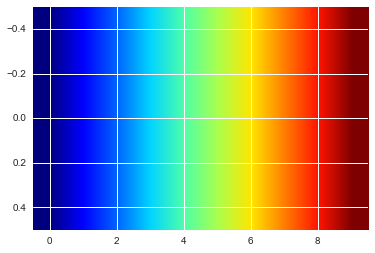

In [26]:
n_colors = 10
#seqcolors = sns.diverging_palette(250, 10, sep=20, n=n_colors, center='dark')
#sns.plt.show(sns.palplot(seqcolors))
seqcolors = plt.get_cmap('jet', n_colors)
gradient = np.atleast_2d(np.linspace(0, 1, seqcolors.N))
plt.imshow(gradient, aspect='auto', cmap=seqcolors)
seqcolors = [rgb2hex(seqcolors(i)[:3]) for i in range(seqcolors.N)]

In [27]:
#colors = pal.linear_map(errors['error'].values, seqcolors.as_hex())
colors = pal.linear_map(errors['error'].values, seqcolors)
a = np.linspace(errors['error'].min(), errors['error'].max(), len(seqcolors))

The colormap associate a color to a specific range of errors. Shades of blule are associated to smaller errors while the opposite, higher errors, is associate to shades of red.

In [28]:
source = ColumnDataSource(data=dict(batch=errors['batch'], 
                                    rate=errors['rate'], 
                                    error=errors['error'],
                                    zeros=np.zeros(errors['error'].shape[0]),
                                    color=colors))

The graph is interactive, you can play with it!

In [29]:
from bokeh.models import Rect, Range1d

tools = "box_select, reset, wheel_zoom, save"

fig = bk.figure(tools=tools, plot_width=500, plot_height=350, title=None)
fig.xaxis.axis_label = 'Batch Size'
fig.xaxis.axis_label_text_font_size = '9pt'
fig.yaxis.axis_label = 'Learning Rate'
fig.yaxis.axis_label_text_font_size = '9pt'

fig.scatter('batch', 'rate', source=source, color='color')

unselect_rectangle = Rect(line_alpha=0, fill_alpha=0)
colour_bar_range = Range1d(errors['error'].min(), errors['error'].max())
colour_bar = bk.figure(tools=tools, width=150, height=350, title=None, 
                       y_range=colour_bar_range)
colour_bar.yaxis.axis_label = "Error"
colour_bar.yaxis.axis_label_text_font_size = '9pt'

colour_bar.rect('zeros', 'error', 0.1, 0.0001, name='colour_bar',
                source=source, color='white')
delta = (errors['error'].max() - errors['error'].min()) / (n_colors-1)
colour_bar.rect(np.zeros(len(a)), a, 0.1, delta, 
                name='colour_bar_2', color=seqcolors)
                
render = colour_bar.select(name='colour_bar')
render.nonselection_glyph = unselect_rectangle
render2 = colour_bar.select(name='colour_bar2')
render2.nonselection_glyph = unselect_rectangle

colour_bar.xgrid.grid_line_color = None
colour_bar.ygrid.grid_line_color = None
colour_bar.xaxis.major_label_text_font_size = '0pt'
colour_bar.xaxis.major_tick_line_color = None
colour_bar.xaxis.minor_tick_line_color = None

p = bk.gridplot([[colour_bar, fig]])

It is possible to highlight a region in the plot or select a range of values in the left bar. To make a multiple selection, press the SHIFT key. To clear the selection, press the ESC key.

In [30]:
bk.show(p)

**Remark**: selection sometimes looks different because there might be too few or too many examples in that area

If you want to further explore a particular region of the graph, or change dataset parameters please go back to the dataset definition or change slider values for batch size and learning rate.

The picture allows to explore the different regions of parameters combination. It seems that in order to lower the error it is neccessary to use low sized batch. Learning rate does not affect the error much, but overall it seems that the correct choice for learning rate is specific for each batch size.

### 3.2 Activation units

In previous examples we used a single type of activation function. In the next example we vary activation function to see the effects on neural network performance. Along tanh, we use the *Sigmoid* function and rectified linera unit (*ReLU*). Along the activation function we would like to show how performance is affected by the choice of learning rate, the batch size and the number of neurons in the hidden layer.

In the next paragraphs we perform different type of tests. In the first test we fix learning rate and number of hidden unit and vary activation function and batch size. In the second test we fix batch size and number of hidden unit and vary activation function and learning rate. Finally in the third test we fix learning rate and batch size and we vary the number of hidden unit activation function. For each test we record the error as in previous examples. The number of epochs is fixed at 25 for all tests.

**First test**: fix learning rate and hidden units and vary batch size and activation function. The number of hidden units is 10, while the learning rate is the default 0.01. You can change the batch sizes to test with the slider below. 

In [31]:
hidden_size = 10
learning_rate = 0.01

units = {'tanh': 'red', 
         'sigmoid': 'blue', 
         'relu': 'green'}

In [32]:
batch_source = ColumnDataSource(data=dict(batch=[]))

In [33]:
@interact(start=(0,100,10), stop=(10**2, 10**3, 100), increment=(10, 100, 10))
def update_b(start=10, stop=100, increment=10):
    batch_source.data['batch'] = np.arange(start, stop, increment)

In [34]:
errors = pd.DataFrame([a for a in multitest(units.keys(), [hidden_size],
                                            batch_source.data['batch'],  
                                            [learning_rate], 
                                            X_train, y_train, X_test, y_test)])

errors.columns = ['activation', 'hidden', 'batch', 'rate', 'error']

In [35]:
activation_group = errors.groupby('activation')

In [36]:
fig = bk.figure(tools=tools, 
                plot_width=500, 
                plot_height=350, 
                title=None)
fig.xaxis.axis_label = 'Batch Size'
fig.xaxis.axis_label_text_font_size = '9pt'
fig.yaxis.axis_label = 'Error'
fig.yaxis.axis_label_text_font_size = '9pt'

for name in units:
    fig.line(activation_group.get_group(name)['batch'],
             activation_group.get_group(name)['error'],
             legend=name, color=units[name])
bk.show(fig)

Batch size affects both speed and accuracy. A larger batch size allows for faster computation because the gradient is calculated simultaneously for all the examples in the batch using matrix computation. This is especially true using GPU. On the other side, for improving accuracy, the optimal batch size is problem dependent. The gradient calculated for a batch size is an estimation of the true gradient. A larger batch size provides a better estimate for the gradient. However there might be two consideration worth doing. First a noisy estimate (smaller batch size) can be useful sometimes because it may help to escape or jump local minima. Second if the dataset is redundant (and in the case of a sinusodi it is) the gradient of a sufficent large batch (but not as large as the whole dataset) is quite similar to other batch's gradient and a good approximation of the true one. For example given a batch as large as the number of examples in a complete sinusoid cycle, the gradient for each batch is really similar in our example (the sinusoid repeat itself). For this reasons increasing the batch size in the example above does not improve sensibly the error for relu and tanh. Moreover it can be seen that sigmoid error actually gets worse as batch size increase. This is possibly due to saturation of sigmoid.

**Second test**: fix batch size and hidden units and vary learning rate and activation function. The batch size it is fixed at 50 and the number of hidden units is 10. You can change the learning rates to test with the slider below. 

In [37]:
batch_size = 50
learning_source = ColumnDataSource(data=dict(rate=[]))

In [38]:
@interact(start=(1./10**3, 2./10**2, 1./10**3), stop=(1./10**2, 2./10, 1./10**2), increment=(1./10**3, 1./10**2, 1./10**2))
def update_r(start=0.01, stop=0.1, increment=0.01):
    learning_source.data['rate'] = np.arange(start, stop, increment).astype(np.float32)

In [39]:
errors = pd.DataFrame([a for a in multitest(units.keys(), [hidden_size],
                                            [batch_size],  
                                            learning_source.data['rate'], 
                                            X_train, y_train, X_test, y_test)])

errors.columns = ['activation', 'hidden', 'batch', 'rate', 'error']

In [40]:
activation_group = errors.groupby('activation')

In [41]:
fig = bk.figure(tools=tools, 
                plot_width=500, 
                plot_height=350, 
                title=None)
fig.xaxis.axis_label = 'Learning Rate'
fig.xaxis.axis_label_text_font_size = '9pt'
fig.yaxis.axis_label = 'Error'
fig.yaxis.axis_label_text_font_size = '9pt'

for name in units:
    fig.line(activation_group.get_group(name)['rate'],
             activation_group.get_group(name)['error'],
             legend=name, color=units[name])
bk.show(fig)

Learning rate affects the speed at which the neural network is learning. With a larger learning rate the speed increases and, since the number of epoch is fixed, it achieves better (lower) error. However increasing further learning rate increase the magnitude of the weights and potentially they become become too big with a resulting tiny gradient, reaching a plateu and do not increase accuracy further. Try to increase learning rate up to 0.2 and see what happens.

**Third test**: fix batch size and learning rate and vary number of hidden units and activation function. You can change the number of hidden units to test with the slider below. 

In [42]:
batch_size = 50
hidden_source = ColumnDataSource(data=dict(n_hidden=[]))

In [43]:
@interact(start=(0,100,10), stop=(10**2, 10**3, 100), increment=(10, 100, 10))
def update_h(start=10, stop=100, increment=10):
    hidden_source.data['n_hidden'] = np.arange(start, stop, increment)

In [44]:
errors = pd.DataFrame([a for a in multitest(units.keys(), hidden_source.data['n_hidden'],
                                            [batch_size],  
                                            [learning_rate], 
                                            X_train, y_train, X_test, y_test)])

errors.columns = ['activation', 'hidden', 'batch', 'rate', 'error']

In [45]:
activation_group = errors.groupby('activation')

In [46]:
fig = bk.figure(tools=tools, 
                plot_width=500, 
                plot_height=350, 
                title=None)
fig.xaxis.axis_label = '# hidden unit'
fig.xaxis.axis_label_text_font_size = '9pt'
fig.yaxis.axis_label = 'Error'
fig.yaxis.axis_label_text_font_size = '9pt'

for name in units:
    fig.line(activation_group.get_group(name)['hidden'],
             activation_group.get_group(name)['error'],
             legend=name, color=units[name])
    
bk.show(fig)

In general the number of hidden units is a parameter that depends on several aspects, some of them are: the number of input and output units, the number of training cases, the amount of noise, the complexity of the function to be learned, the activation function, the training algorithm and the amount of regularization.

The best number of hidden units is usually determined by training a large number of NN and pick the one that perform the best. As a rule of thumb, having too few hidden units may result in an higher training and test error due to underfitting. Conversely too many hidden units may get low training error but high test error this time due to overfitting.

In our example it seems that relu and tanh are not strongly affected by the number of hidden units. This indicates that the learning function is too simple for the task and changing the number of hidden units does not increase its accuracy. On the contrary sigmoid shows a somewaht erratic behavior and the number of hiddend units makes the error vary consistently.

## 4 Tuning Learning Rate

Learning rate is an important parameter. A good choice of learning rate is vital for the netural network to learn properly. However selecting and using a fixed learning rate can be tricky. If we use a big learning rate, the learning is sped up but the weights of each hidden unit will become either very big and positive or very big and negative and the error derivative will become tiny. This is a plateau, not a local minimum. In order to speed up learning and avoiding to finish in a plateau it is possible to vary learning rate adaptively. In the following sections we'll look at two methods to do that. 

The settings for this experiment are fixed at the best combination of parameters found in previous experiments. Batch size, number of hidden unit and activation function are fixed, we are interested in showing that learning rate can be set without worrying too much to find the best possible value.

### 4.1 Momentum Method

To speed up learning, instead of using gradient to change the weights, momentum uses the gradient to change velocity. At the beginning the weights are updated by the gradient but once they acquire velocity they no longer do steepest descent. The momentum they acquired make them go in the previous direction. The `momentum` parameter is a decay factor for the velocity at previous time. Nesterov is a particular type of momentum where the gradient is not calculated at the current position and then updated with the past velocity, but it is calculated at the position after we update it with the past velocity. 

In [47]:
hidden_size = 10
batch_size = 50
activation = tf.nn.tanh
momentum = 0.9
learning_rate = 0.01

n_inputs = X_train.shape[1]

x = tf.placeholder(tf.float32, [None, n_inputs])
y_ = tf.placeholder(tf.float32, [None, 1])

W_x = tf.Variable(tf.truncated_normal([n_inputs, hidden_size], stddev=0.05))
b_h = tf.Variable(tf.truncated_normal([hidden_size], stddev=0.05))

h = activation(tf.matmul(x, W_x) + b_h)

W_h = tf.Variable(tf.truncated_normal([hidden_size, 1], stddev=0.05))
b_y = tf.Variable(tf.truncated_normal([1], stddev=0.05))

y = tf.matmul(h, W_h) + b_y

loss = tf.reduce_mean(tf.square(y - y_))

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum)
train = optimizer.minimize(loss)

sess = tf.Session()

sess.run(tf.initialize_all_variables())

In [48]:
epochs = 50

train_batches = len(X_train) // batch_size 
for epoch in range(epochs):
    for i in range(train_batches):
        batch_x = X_train[i*batch_size:(i+1)*batch_size]
        batch_y = y_train[i*batch_size:(i+1)*batch_size]
        sess.run(train, feed_dict={x: batch_x, y_:batch_y})

preds = sess.run(y, feed_dict={x: X_test})
err = np.sqrt(sk.metrics.mean_squared_error(preds, y_test))
print('Model Error: %f' % err)

Model Error: 0.016687


In [49]:
fig = bk.figure(plot_width=750, 
                plot_height=450,
                title="Data")

fig.circle(t[-len(preds):], y_noisy[-len(preds):], color='red', 
           size=2, legend='sinusoid + noise')
fig.line(t[-len(preds):], y_clean[-len(preds):], color='green', legend='clean sinusoid')
fig.line(t[-len(preds):], [u for u in preds.flat], color='blue', legend='prediction')

bk.show(fig)

The momentum allows mainly to avoid oscillations in the direction of high curvature by combining gradient with different sign and build up speed in directions with low but consistent gradient. Adding momentum helps the algorithm to converge faster. This can be seen in the previous example where the error is lower than that of the Neural Network without momentum. Since we have a fixed number of epochs, increasing convergence speed makes the algorithm use the available time more profitably.

### 4.2 Adaptive Learning Rate (rmsprop)

Rmsprop is another type of algorithm to vary the weights adaptively. It uses the sign of the gradient to decide the direction of the update, and then calculate the update step separately for each weight with a rule. It keeps a moving average for the gradient of each weight and then it calculates the update diving the gradient by the square root of the moving average.

The parameters `rho` and `epsilon` are, respectively, a decay factor for the moving average and the weight of the current gradient when adding it to the moving average.

In [50]:
hidden_size = 10
batch_size = 50
activation = tf.nn.tanh
learning_rate = 0.001
decay = 0.9
epsilon=1e-6

n_inputs = X_train.shape[1]

x = tf.placeholder(tf.float32, [None, n_inputs])
y_ = tf.placeholder(tf.float32, [None, 1])

W_x = tf.Variable(tf.truncated_normal([n_inputs, hidden_size], stddev=0.05))
b_h = tf.Variable(tf.truncated_normal([hidden_size], stddev=0.05))

h = activation(tf.matmul(x, W_x) + b_h)

W_h = tf.Variable(tf.truncated_normal([hidden_size, 1], stddev=0.05))
b_y = tf.Variable(tf.truncated_normal([1], stddev=0.05))

y = tf.matmul(h, W_h) + b_y

loss = tf.reduce_mean(tf.square(y - y_))

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=decay,
                                      epsilon=epsilon)
train = optimizer.minimize(loss)

sess = tf.Session()

sess.run(tf.initialize_all_variables())

In [51]:
epochs = 50

train_batches = len(X_train) // batch_size 
for epoch in range(epochs):
    for i in range(train_batches):
        batch_x = X_train[i*batch_size:(i+1)*batch_size]
        batch_y = y_train[i*batch_size:(i+1)*batch_size]
        sess.run(train, feed_dict={x: batch_x, y_:batch_y})

preds = sess.run(y, feed_dict={x: X_test})
err = np.sqrt(sk.metrics.mean_squared_error(preds, y_test))
print('Model Error: %f' % err)

Model Error: 0.016039


In [52]:
fig = bk.figure(plot_width=750, 
                plot_height=450,
                title="Data")

fig.circle(t[-len(preds):], y_noisy[-len(preds):], color='red', size=2, 
           legend='sinusoid + noise')
fig.line(t[-len(preds):], y_clean[-len(preds):], color='green', legend='clean sinusoid')
fig.line(t[-len(preds):], [u for u in preds.flat], color='blue', legend='prediction')

bk.show(fig)

It is hard to chose a single global learning rate, because the magnitude of the gradient can be very different and can change during learning. Rmsprop can achieve faster convergence with a better choice of single weights update rule. As in previous example with momentum, speeding up learning can achieve a better result with the same amount of time (remember the number of epochs is fixed).